# Classification with Machine Learning classifiers and the Feature Histogram of Oriented Gradients (HOG)



Let's start importing some libraries.
In particular, `sklearn` is the library for the **Machine Learning stuff**!

In [1]:
import sklearn
import numpy as np
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix # to compute final accuracy
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from glob import glob
from os.path import join
import cv2
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm # to see the progressive computation of something
import time


The seed is important to have **deterministic** experiments.

The `seed()` method is used to initialize the random number generator.
The random number generator needs a number to start with (a seed value), to be able to generate a random number.

In [2]:
np.random.seed(1821) #we want a deterministic shape. It is important to compare a deterministic result - usable for final project
# look the information in https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html

### Data


1.   Connect to Google Drive
1.   Upload the `.zip` file containing the *faces* dataset
2.   Unzip the file using the following comand. Dataset folders will appear in `/content`




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q '/content/drive/MyDrive/Digital Transformation Management/Secondo Anno 2022-2023/Machine Learning/Documents for project/archive_of_face_2.zip' -d /content

# Functions and Classes
`get_labels()` is a function that receives a name (`string`) and returns the class (`int`), following this:

*   \man: 0
*   woman: 1

Example: /content/faces/man/man_1386.jpg → 0

Example: /content/faces/woman/woman_3023.jpg → 1

# Attention
It is important use "\man" instead of "man" because the latest name has a conflict with the class "woman".

In [5]:
def get_labels(name):
    if '/man' in name:
        return 0
    elif 'woman' in name:
        return 1
    else:
        raise NotImplementedError('Not existing class!')

`extract_feature()` is a function that, given a list of images, compute a Feature Descriptor.
We are going to use two libraries: `opencv` to handle images (opening, resizing) and `skimage` to compute features.

Specifically:
* `feat_type=1` → function computes HOG
* `feat_type=2` → function computes LBP
* `feat_type=3` → function does not computes any feature, but simply unroll the input image

**Tools**:
*   `cv2.imread()`: open an image (0: gray level, 1: BGR)
*   `cv2.resize()`: resize an image
*   `hog()`: compute HOG feature
*   `lbp()`: compute LBP feature

Be aware that the feature computation time (and the final accuracy of the model) are strictly related to the image size!


In [6]:
def extract_features(images, feat_type, img_size):

    labels = []
    features = []
    #t1 = time.time()

    for image in images: #tqdm(images): #tqdm comand let to se the progression value

        # open the image
        img = cv2.imread(image, 0)
        # remember 0 for BN and 1 for RGB

        # resize the image
        img = cv2.resize(img, (img_size, img_size))
        # important for our calculation

        # compute the features
        if feat_type == 'hog':
            feat = hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1)) # same value of the documentetion
        elif feat_type == 'lbp':
            feat = np.ravel(local_binary_pattern(img, P=100, R=5)) # first "img" to resize the image
        elif feat_type == 'img':
            img = img / 255.0
            feat = np.ravel(img) # is able to unroll a matrix in a single array movin from N tomension to 1 dimension
        else:
            raise NotImplementedError('Not implemented feature!')

        # append features and labels
        features.append(feat)
        labels.append(get_labels(image))
    #t2 = time.time()
    return features, labels

Let's create a list of all images available in the dataset.

**Tools**:
* `join()`: joins one or more path components intelligently. The return value is the concatenation of path.
* `glob()`: returns a possibly empty list of path names that match names. Wildcards (in that case `*` are allowed!)

In [7]:
dataset_path = '/content/faces'
images = glob(join(dataset_path, '*', '*.jpg'))
print('Images: ', len(images))

Images:  18978


in this case it is essential to have a **training**, **validation** and **test** sets. 

Training data are used to train the model, while the validation split is used to assess performance.

Here, we use validation and test set as synonymous, since we do not have a real test set.

We put **70% of data in training**, **20% in validation**, and the remaining **10% in the test set**.

In [8]:
np.random.shuffle(images)
# define the percentage of the training list of data
perc_train = 0.7
perc_val = 0.9
trainset = images[:int(perc_train*len(images))]
valset = images[int(perc_train*len(images)):int(perc_val*len(images))]
testset = images[int(perc_val*len(images)):]
print('Total: {} splitted in Train: {}, Val: {} and Test: {}'.format(len(images), len(trainset), len(valset), len(testset)))

Total: 18978 splitted in Train: 13284, Val: 3796 and Test: 1898


Here, we define two important elements: the **size of the images** (used to compute feature descriptors) and the **type of features**.
We use a **progress bar** (`tqdm`) to show the state of the feature computation!

In [9]:
img_size = 224 # the image size
feature_type = 'hog' #['hog', 'lbp', 'img']
t1 = time.time()
train_x, train_y = extract_features(trainset, feature_type, img_size)
val_x, val_y = extract_features(valset, feature_type, img_size)
test_x, test_y = extract_features(testset, feature_type, img_size)
t2 = time.time()

### Classifier
Now that the feature extraction is ended, we can define our classifiers.
As in the previous case, we start our analysis from the SVM.

In [10]:
clf = svm.SVC(gamma=0.001, C=100., kernel='rbf', verbose=False)

### Training
Now we are ready for the training!
With `sklearn` library is tremendously simple, we just need training data (`train_x` and the related labels `train_y`) and pass them to the classifier.

**Tools**:
-   `model.fit()`: fit the provided model with training data.

In [11]:
clf.fit(train_x, train_y)

SVC(C=100.0, gamma=0.001)

### Validation

In [12]:
clf.score(val_x, val_y)

0.8422023182297155

### Testing
Now we are reading to use our classifier! The trained classifier output the labels (as defined above) for the classification task.

Tools:
  - `model.predict()`: predict the class of the given data.

In [13]:
y_pred = clf.predict(test_x)
print('Predicted {} samples: {}'.format(len(y_pred), y_pred))

Predicted 1898 samples: [0 1 1 ... 0 1 1]


It's time to understand the final performance of the trained classifier.

**Tools**:
   * `accuracy_score()`: Accuracy classification score. The set of labels predicted for a sample must exactly match the corresponding set of labels of GT.

In [14]:
print('Final Accuracy: {:.3f}'.format(accuracy_score(test_y, y_pred)))

Final Accuracy: 0.857


### Confusion matrix

We can also compute the confusion matrix to further understand the performance on the trained model.

**Tools**:
   * `confusion_matrix()`: computes confusion matrix to evaluate the accuracy of a classification.
   * `plot_confusion_matrix()`: plots Confusion Matrix (it is deprectaed and will be removed in future versions of the library).

In [17]:
def compute_classif_score(matrix_elab):
  a = [ [round(matrix_elab.item((r,c))/sum(matrix_elab[r]),3) for c in range(0, len(matrix_elab))] for r in range(0, len(matrix_elab))] 
  return np.array(a)

In [18]:
# compute the confusion matrix
matrix = confusion_matrix(test_y, y_pred)
print(matrix)
print(compute_classif_score(matrix))
# confusion matrix with normalized values
print(matrix.diagonal() / matrix.sum(axis=1))

[[807 117]
 [155 819]]
[[0.873 0.127]
 [0.159 0.841]]
[0.87337662 0.84086242]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


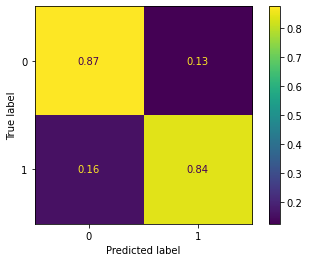

In [16]:
# plot the confusion matrix (colors are useful for a visual evaluation)
plot_confusion_matrix(clf, test_x, test_y, normalize='true')
plt.show()